In [1]:
from custom_dataset.segdataset import InstanceSegmentationDataset
from torch.utils.data import DataLoader
import json

import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
import evaluate
import logging
from utils import rs_utils
from datetime import datetime
from transformers import SegformerImageProcessor

In [2]:
#--- root 
root_dir = '/disk3/eric/dataset/Weapon_System/segmentation_pipes'

#--- time
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

In [3]:
# for fewshot
id2label = {
    0:"background",
    1:"object"
}
label2id = {v: k for k, v in id2label.items()}

In [4]:
#-----------
_VERSION = "070"
_EPOCHS = 50
_MODEL_SAVE = True
_MODEL_VERSION = "nvidia/mit-b5"
_MODEL_VERSION_SAVE = _MODEL_VERSION.split("/")[-1]
_BATCH_SIZE = 1
_DEVICE = "cuda:1"
#----------

In [5]:
#----------------------
from custom_dataset.segdataset import FewShotSegDataset


image_processor = SegformerImageProcessor(reduce_labels=False,size={"height": 448, "width": 448})

train_dataset = FewShotSegDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = FewShotSegDataset(root_dir=root_dir, image_processor=image_processor, train=False)

#train_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
#valid_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=_BATCH_SIZE, collate_fn=train_dataset.my_collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=_BATCH_SIZE, collate_fn=train_dataset.my_collate_fn)

[('Zamak__part_21.png', 'city_part_4.png'), ('Zamak__part_21.png', 'city_part_9.png'), ('Zamak__part_21.png', 'city_part_13.png'), ('Zamak__part_21.png', 'city_part_10.png'), ('Zamak__part_21.png', 'city_part_24.png'), ('Zamak__part_21.png', 'city_part_3.png'), ('Zamak__part_21.png', 'city_part_19.png'), ('M2A1Slammer2__part_24.png', 'city_part_4.png'), ('M2A1Slammer2__part_24.png', 'city_part_9.png'), ('M2A1Slammer2__part_24.png', 'city_part_13.png'), ('M2A1Slammer2__part_24.png', 'city_part_10.png'), ('M2A1Slammer2__part_24.png', 'city_part_24.png'), ('M2A1Slammer2__part_24.png', 'city_part_3.png'), ('M2A1Slammer2__part_24.png', 'city_part_19.png'), ('Zamak__part_18.png', 'city_part_4.png'), ('Zamak__part_18.png', 'city_part_9.png'), ('Zamak__part_18.png', 'city_part_13.png'), ('Zamak__part_18.png', 'city_part_10.png'), ('Zamak__part_18.png', 'city_part_24.png'), ('Zamak__part_18.png', 'city_part_3.png'), ('Zamak__part_18.png', 'city_part_19.png'), ('M5Sandstorm__part_17.png', 'city_

/home/eric/anaconda3/envs/trex/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
# define model
from models.custom_segformer import FewShotFormer

seg_model = FewShotFormer.from_pretrained(_MODEL_VERSION,
                                        num_labels=2,
                                        id2label=id2label,
                                        label2id=label2id,
                                        force_download=False                                       
                                        )

# model freeze

# model freeze 
for param in seg_model.parameters():
    param.requires_grad = False

# decoder unfreeze 
for param in seg_model.decode_head.parameters():
    param.requires_grad = True

/home/eric/anaconda3/envs/trex/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/eric/anaconda3/envs/trex/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of FewShotFormer were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_hea

In [7]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

dinov2_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
#backbone_model.to(_DEVICE)

# model freeze 
for param in dinov2_model.parameters():
    param.requires_grad = False

Using cache found in /home/eric/.cache/torch/hub/facebookresearch_dinov2_main
/home/eric/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/eric/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/eric/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [8]:
#-- model to device
seg_model.load_state_dict(torch.load("/disk3/eric/checkpoints/military_fewshot_seg/090_mit-b5_fewshotformer_best_epoch_2_miou_0.9746.pt"))

seg_model = seg_model.to(_DEVICE)
dinov2_model = dinov2_model.to(_DEVICE) 


In [9]:
import random
select = random.randint(0, 20)

# Create an iterator for the valid_dataloader outside the loop
iterator = iter(valid_dataloader)

for i in range(select):
    try:
        batch = next(iterator)  # Get the next batch from the iterator
    except StopIteration:
        # Handle the case where the iterator has exhausted the data
        print("End of data reached!")
        break

support_pixel_values, support_labels = batch["support"]['images'].to(_DEVICE), batch["support"]["labels"].to(_DEVICE) 
query_pixel_values, query_labels = batch["query"]['images'].to(_DEVICE), batch["query"]["labels"].to(_DEVICE) 
labels = query_labels

filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/images/Zamak__part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/labels/Zamak__part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/images/city_part_15.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/labels/city_part_15.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/images/Zamak__part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/labels/Zamak__part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/images/city_part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/labels/city_part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/images/Zamak__part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/labels/Zamak__part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/images/c

In [10]:
#-----
patch_token = dinov2_model.forward_features(query_pixel_values)
patch_token = patch_token["x_norm_patchtokens"]
patch_token = patch_token.reshape([query_pixel_values.shape[0],-1,32,32])

In [11]:
outputs = seg_model(pixel_values=support_pixel_values, labels=labels,dino_features = patch_token)
loss, logits = outputs.loss, outputs.logits

support_states  torch.Size([1, 768, 112, 112])
query_states  torch.Size([1, 1024, 32, 32])
query_states  torch.Size([1, 768, 112, 112])
mask type :  <class 'torch.Tensor'>
mask shape :  torch.Size([1, 448, 448])
weighted_support_states torch.Size([1, 768, 112, 112])
all_factors :  torch.Size([1, 2304, 112, 112])


In [12]:
with torch.no_grad():
    upsampled_logits = nn.functional.interpolate(
        logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
    )
    predicted = upsampled_logits.argmax(dim=1)

In [13]:
import matplotlib.pyplot as plt
support_pixel_values, support_labels = support_pixel_values.to("cpu"), support_labels.to("cpu")
query_pixel_values, query_labels = query_pixel_values.to("cpu"), query_labels.to("cpu")

In [14]:
import utils.rs_utils

In [15]:
query_pixel_values.shape

torch.Size([1, 3, 448, 448])

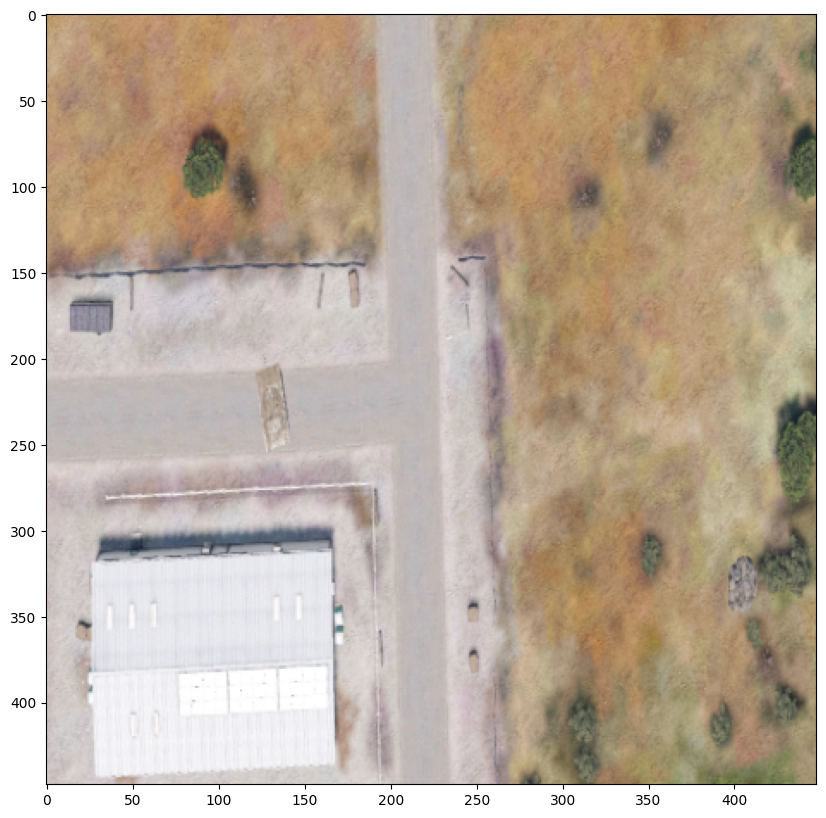

In [16]:
rs_utils.torch_display(support_pixel_values,True,True)

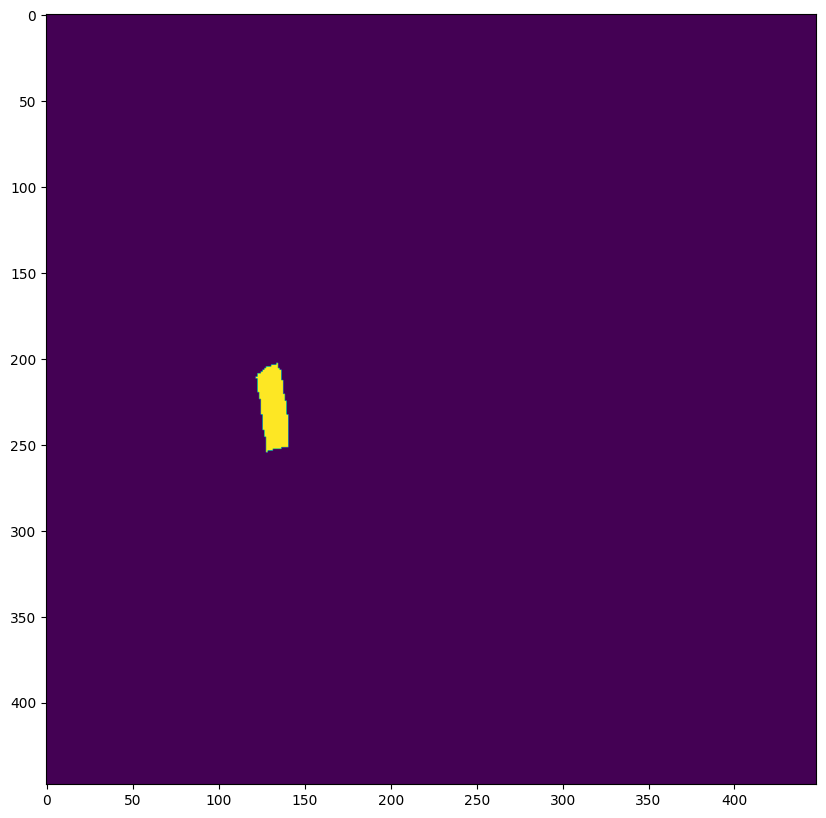

In [17]:
fig_size= (10,10)
plt.figure(figsize=fig_size)
plt.imshow(support_labels[0,:])

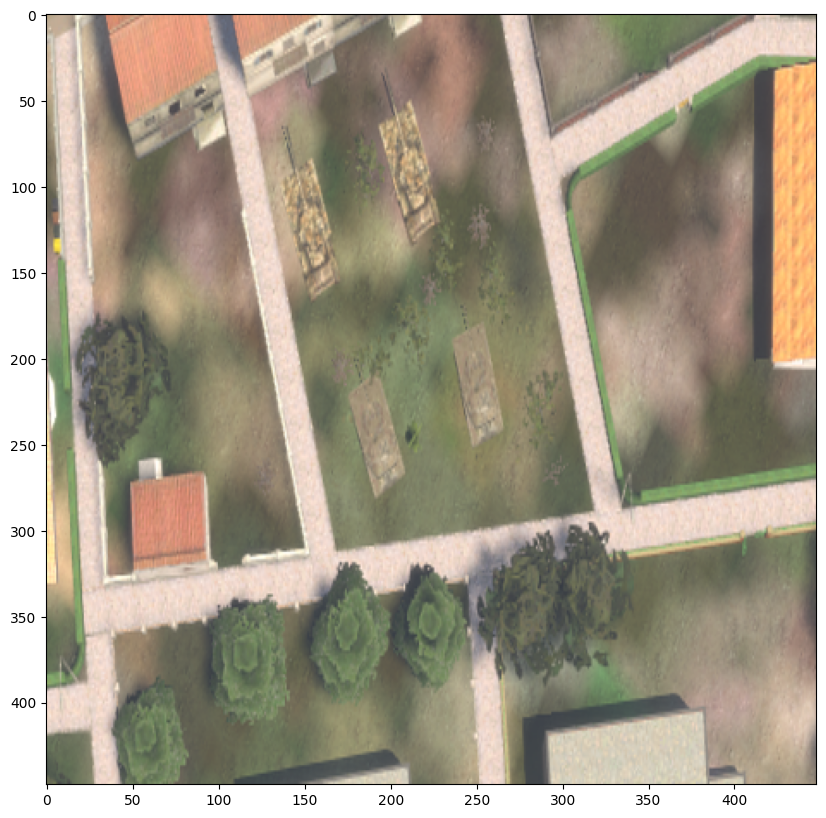

In [18]:
rs_utils.torch_display(query_pixel_values,True,True)

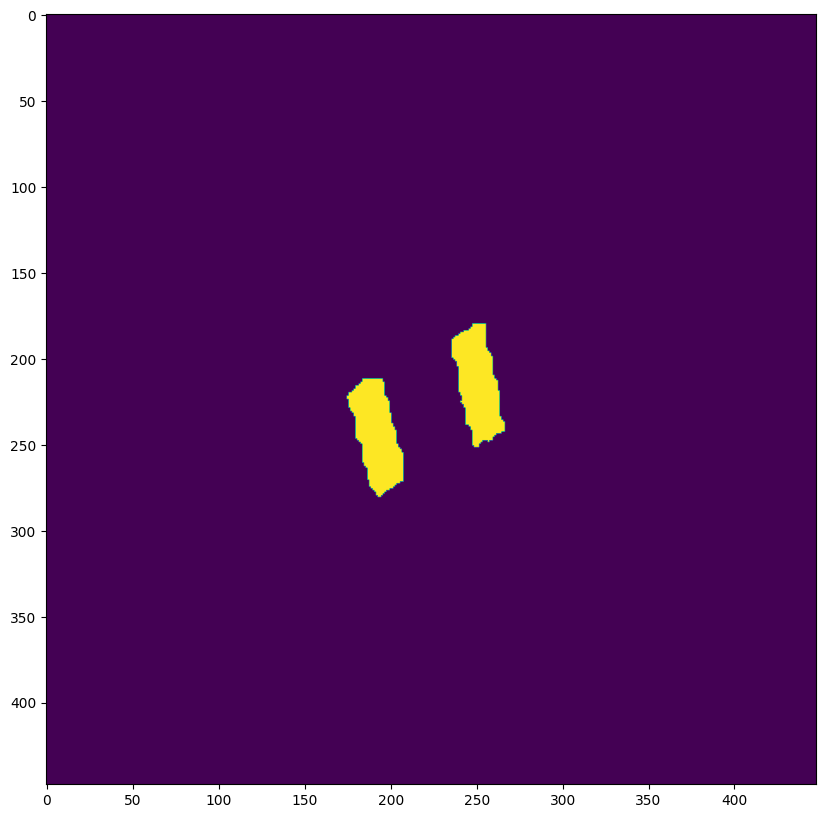

In [19]:
predicted = predicted.to("cpu")
fig_size= (10,10)
plt.figure(figsize=fig_size)
plt.imshow(predicted[0,:])

In [20]:
batch[0].keys()

KeyError: 0

In [ ]:
batch[0]['pixel_values'].shape

torch.Size([2, 3, 448, 448])

In [ ]:
batch[1].keys()

dict_keys(['pixel_values', 'labels'])

In [ ]:
support_pixel_values, support_labels = batch[0]["pixel_values"].to(_DEVICE), batch[0]["labels"].to(_DEVICE) 
query_pixel_values, query_labels = batch[1]["pixel_values"].to(_DEVICE), batch[1]["labels"].to(_DEVICE) 
labels = query_labels

In [ ]:
support_pixel_values.shape

torch.Size([2, 3, 448, 448])

In [ ]:
patch_token = dinov2_model.forward_features(query_pixel_values)
patch_token = patch_token["x_norm_patchtokens"]
patch_token = patch_token.reshape([query_pixel_values.shape[0],-1,32,32])

In [ ]:
seg_model.load_state_dict(torch.load("/disk3/eric/checkpoints/military_fewshot_seg/070_mit-b5_fewshotformer_best_epoch_40_miou_0.9765.pt"))

<All keys matched successfully>

In [ ]:
outputs = seg_model(pixel_values=support_pixel_values, labels=labels, dino_features = patch_token)

support_states  torch.Size([2, 768, 112, 112])
query_states  torch.Size([2, 1024, 32, 32])
query_states  torch.Size([2, 768, 112, 112])
mask type :  <class 'torch.Tensor'>
mask shape :  torch.Size([2, 448, 448])
weighted_support_states torch.Size([2, 768, 112, 112])
all_factors :  torch.Size([2, 2304, 112, 112])


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images/M2A1Slammer2__part_13.png


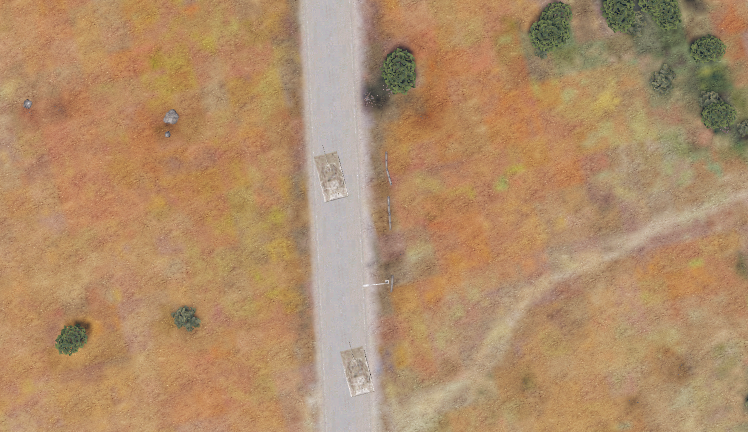

In [ ]:
import random
from PIL import Image
img_root = "/disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images"
rand_id = random.randint(0,len(os.listdir("/disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images")))
img_name = os.listdir(img_root)[rand_id]
image = Image.open(os.path.join(img_root, img_name))
image

In [ ]:
image.size

(748, 432)

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    # Resize the image to the specified size
    transforms.Resize((512, 512)),  # (height, width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
transformed_image = transform(image)

In [ ]:
transformed_image.shape

torch.Size([3, 512, 512])

In [ ]:
transformed_image_ = transformed_image.unsqueeze(0)

In [ ]:
transformed_image_.shape

torch.Size([1, 3, 512, 512])

In [ ]:
model.eval()
outputs = model(transformed_image_)

In [ ]:
shape_ = transformed_image.shape[-2:]

upsampled_logits = nn.functional.interpolate(
    outputs['logits'], size=shape_, mode="bilinear", align_corners=False)
predicted = upsampled_logits.argmax(dim=1)

In [ ]:
predicted.shape

torch.Size([1, 512, 512])

In [ ]:
import numpy as np
predicted_np = np.asarray( predicted.permute(1,2,0) )

In [ ]:
id2label

{0: 'background',
 1: 'M2A1Slammer',
 2: 'M5SandstormMLRS',
 3: 'T140Angara',
 4: 'ZamakMRL'}

In [ ]:
colormap = {
    0: (0, 0, 0),        # Black for background
    1: (255, 0, 0),      # Red for M2A1Slammer
    2: (0, 255, 0),      # Green for M5SandstormMLRS
    3: (0, 0, 255),      # Blue for T140Angara
    4: (255, 255, 0)     # Yellow for ZamakMRL
}

In [ ]:
np.unique( predicted_np )

array([0, 1, 3])

In [ ]:
rgb_image = np.repeat(predicted_np, 3, axis=-1)


In [ ]:
for key,value in colormap.items():
    mask = (rgb_image == [key, key, key]).all(axis=-1)
    rgb_image[mask] = value   

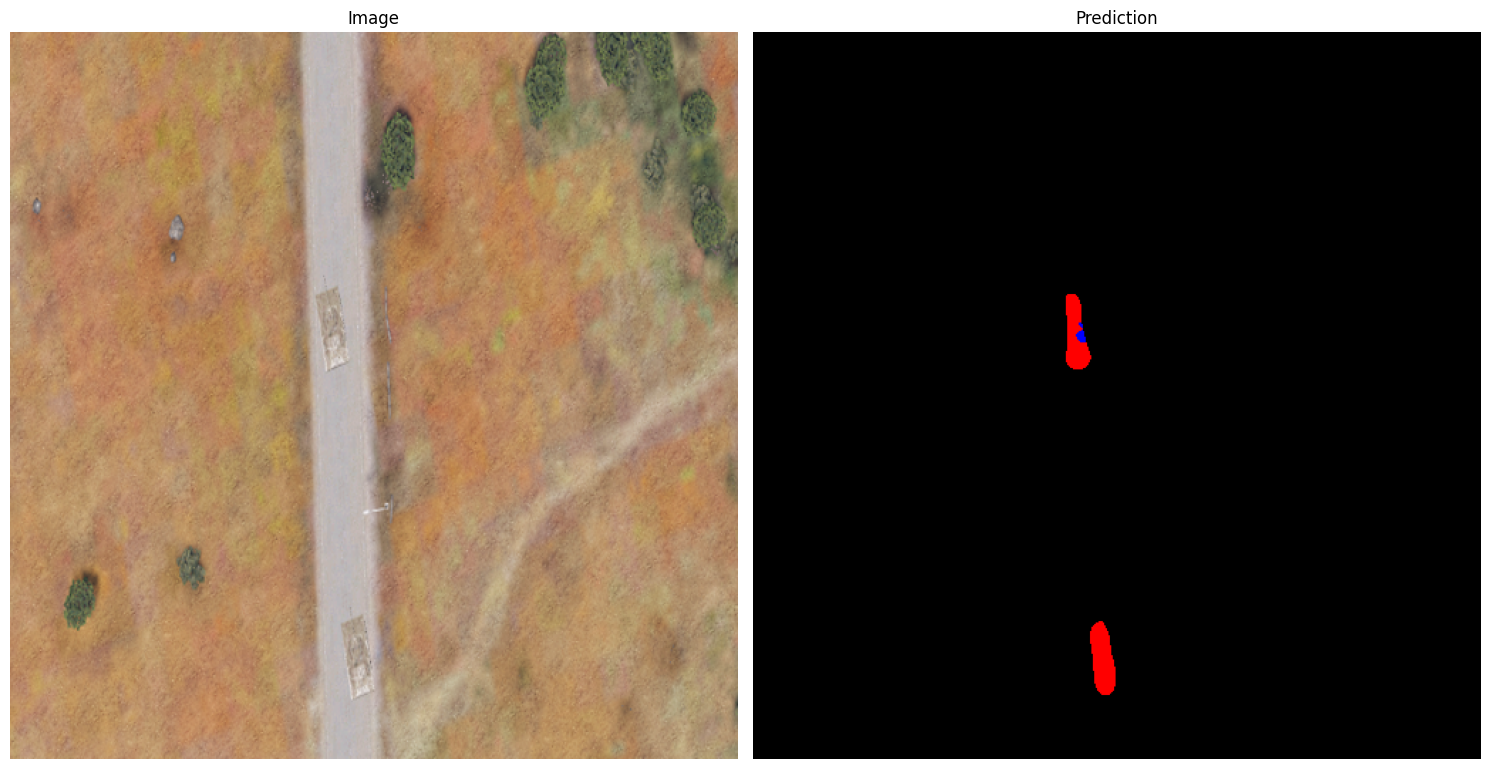

: 

In [ ]:
import matplotlib.pyplot as plt
# Create a figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # 1 row, 2 columns

#----- image was resized
new_size = (512, 512)  # (width, height)

# Resize the image
resized_image = image.resize(new_size)  

# Display the first image in the first subplot
axes[0].imshow(resized_image)
axes[0].set_title("Image")  # Optional: Add a title
axes[0].axis("off")           # Turn off the axes for better visualization

# Display the second image in the second subplot
axes[1].imshow(rgb_image)
axes[1].set_title("Prediction")  # Optional: Add a title
axes[1].axis("off")           # Turn off the axes

# Show the combined figure
plt.tight_layout()
plt.show()